# Classification of animal images using microsoft/resnet-50

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torch.optim import AdamW
import torch.nn as nn

import transformers
# from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
from transformers import AutoImageProcessor, ResNetForImageClassification

from pathlib import Path

from tqdm import tqdm

from sklearn.metrics import f1_score

In [4]:
class Args:
    def __init__(self):
        self.num_epochs = 10
        self.num_workers = 2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 64
        self.model_name = 'microsoft/resnet-50'
        self.lr = 3e-4

args = Args()
args.device

device(type='cuda')

## Unzip files

In [5]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/animals.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/animals')

## Data

Добавить визуализация картинки из каждого из классов

In [6]:
data_dir = Path("/content/drive/MyDrive/animals/photos/train")

In [7]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset

In [9]:
dataset = load_dataset('/content/drive/MyDrive/animals/photos/train')

Resolving data files:   0%|          | 0/37799 [00:00<?, ?it/s]

Computing checksums:  73%|#######3  | 27773/37799 [00:05<00:01, 5551.18it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 37799
    })
})

In [11]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['bear', 'boar', 'empty', 'lynx', 'moose', 'other'], id=None)}

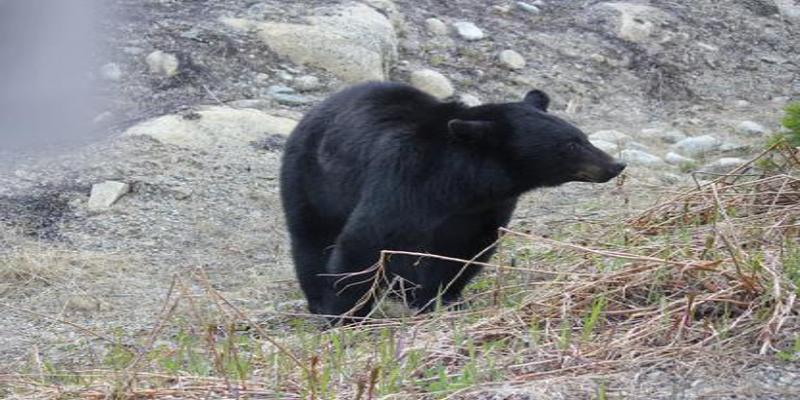

In [12]:
example = dataset["train"][0]
example["image"]

In [13]:
example["label"]

0

In [14]:
labels = dataset["train"].features["label"].names
print(labels)

['bear', 'boar', 'empty', 'lynx', 'moose', 'other']


In [15]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'bear', 1: 'boar', 2: 'empty', 3: 'lynx', 4: 'moose', 5: 'other'}


## Train test split

In [16]:
dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30239
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7560
    })
})

In [17]:
train_dataset = dataset['train']
valid_dataset = dataset['test']

In [18]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 30239
})

In [19]:
num_classes = len(set(train_dataset['label']))
labels = train_dataset.features['label']
num_classes, labels

(6,
 ClassLabel(names=['bear', 'boar', 'empty', 'lynx', 'moose', 'other'], id=None))

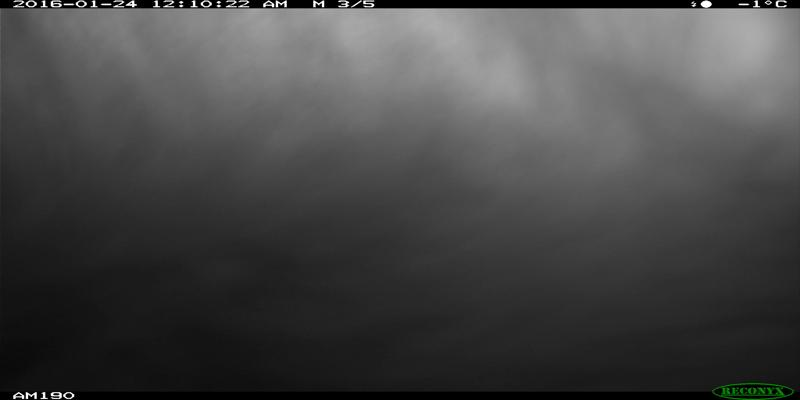

In [20]:
train_dataset[2]['image']

In [21]:
train_dataset[2]['label'], labels.names[train_dataset[2]['label']]

(5, 'other')

## Load extractor

In [22]:
processor = AutoImageProcessor.from_pretrained(args.model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [23]:
processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [24]:
def preprocess(batch):
    inputs = processor(
        batch['image'],
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs

restart from here

In [25]:
prepared_train = train_dataset.with_transform(preprocess)
prepared_valid = valid_dataset.with_transform(preprocess)

In [26]:
def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=args.batch_size, shuffle=True)
valid_dataloader = DataLoader(prepared_valid, collate_fn=collate_fn, batch_size=args.batch_size, shuffle=True)

In [27]:
next(iter(train_dataloader))['pixel_values'].shape, next(iter(train_dataloader))['labels'].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [28]:
next(iter(train_dataloader))['labels']

tensor([1, 4, 1, 5, 2, 0, 0, 4, 2, 0, 2, 5, 4, 2, 2, 2, 4, 2, 5, 2, 5, 1, 4, 5,
        2, 4, 2, 2, 5, 4, 4, 2, 1, 0, 2, 4, 4, 5, 2, 1, 1, 2, 4, 5, 2, 1, 2, 4,
        2, 4, 2, 1, 4, 2, 0, 5, 5, 2, 2, 2, 3, 5, 1, 4])

## Load Model

In [29]:
model = ResNetForImageClassification.from_pretrained(args.model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
model = model.to(args.device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([6, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
optimizer = AdamW(model.parameters(), lr=args.lr, eps=1e-08, weight_decay=0.01)

## Train and Evaluate

In [31]:
def evaluate_step(args, model, dataloader):
    model.eval()
    print('Evaluating')

    predicted_labels = []
    true_labels = []

    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch = {k:v.to(args.device) for k,v in batch.items()}
        labels = batch['labels']

        outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])

        loss, logits = outputs.loss, outputs.logits

        y_pred = torch.argmax(outputs.logits, dim=1)

        predicted_labels.append(y_pred)
        true_labels.append(labels)


    predicted_labels = torch.cat(predicted_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    f1_macro = f1_score(predicted_labels.cpu(), true_labels.cpu(), average='macro')

    return f1_macro.item()

In [32]:
def train_step(args, model, dataloader, optimizer):
    model.train()
    print('Training')
    train_running_loss = 0.0

    predicted_labels = []
    true_labels = []
    counter = 0

    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        counter += 1
        batch = {k:v.to(args.device) for k,v in batch.items()}
        labels = batch['labels']

        outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])

        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        y_pred = torch.argmax(outputs.logits, dim=1)

        predicted_labels.append(y_pred)
        true_labels.append(labels)


    predicted_labels = torch.cat(predicted_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    f1_macro = f1_score(predicted_labels.cpu(), true_labels.cpu(), average='macro')
    epoch_loss = train_running_loss / counter

    return epoch_loss, f1_macro.item()

In [34]:
history_train_loss = []
f1_macro_train_history = []
f1_macro_valid_history = []

for epoch in range(args.num_epochs):
    print(f'Starting epoch {epoch+1}')

    epoch_loss, f1_train_macro = train_step(args, model, train_dataloader, optimizer)
    print(f'Train epoch {epoch + 1} F1-macro = {f1_train_macro}')

    f1_valid_macro = evaluate_step(args, model, valid_dataloader)
    print(f'epoch {epoch + 1} Valid F1-macro = {f1_valid_macro}')

    f1_macro_valid_history.append(f1_valid_macro)
    history_train_loss.append(epoch_loss)
    f1_macro_train_history.append(f1_train_macro)

Starting epoch 1
Training


100%|██████████| 473/473 [13:53<00:00,  1.76s/it]


Train epoch 1 F1-macro = 0.7122664930282102
Evaluating


100%|██████████| 119/119 [02:16<00:00,  1.15s/it]


epoch 1 Valid F1-macro = 0.6197746882454492
Starting epoch 2
Training


100%|██████████| 473/473 [13:17<00:00,  1.69s/it]


Train epoch 2 F1-macro = 0.7344590952009082
Evaluating


100%|██████████| 119/119 [02:07<00:00,  1.07s/it]


epoch 2 Valid F1-macro = 0.7682277939758837
Starting epoch 3
Training


100%|██████████| 473/473 [13:18<00:00,  1.69s/it]


Train epoch 3 F1-macro = 0.7671308901167072
Evaluating


100%|██████████| 119/119 [02:07<00:00,  1.07s/it]


epoch 3 Valid F1-macro = 0.7219061057056012
Starting epoch 4
Training


100%|██████████| 473/473 [13:14<00:00,  1.68s/it]


Train epoch 4 F1-macro = 0.7890328370856449
Evaluating


100%|██████████| 119/119 [02:09<00:00,  1.09s/it]


epoch 4 Valid F1-macro = 0.8140442485498465
Starting epoch 5
Training


100%|██████████| 473/473 [13:13<00:00,  1.68s/it]


Train epoch 5 F1-macro = 0.8182405402508182
Evaluating


100%|██████████| 119/119 [02:07<00:00,  1.07s/it]


epoch 5 Valid F1-macro = 0.8454184891099189
Starting epoch 6
Training


100%|██████████| 473/473 [13:17<00:00,  1.69s/it]


Train epoch 6 F1-macro = 0.8384205965242195
Evaluating


100%|██████████| 119/119 [02:08<00:00,  1.08s/it]


epoch 6 Valid F1-macro = 0.8522432885087788
Starting epoch 7
Training


100%|██████████| 473/473 [13:13<00:00,  1.68s/it]


Train epoch 7 F1-macro = 0.8541055844173727
Evaluating


100%|██████████| 119/119 [02:09<00:00,  1.09s/it]


epoch 7 Valid F1-macro = 0.8527743216643925
Starting epoch 8
Training


100%|██████████| 473/473 [13:16<00:00,  1.68s/it]


Train epoch 8 F1-macro = 0.8672088732232588
Evaluating


100%|██████████| 119/119 [02:05<00:00,  1.05s/it]


epoch 8 Valid F1-macro = 0.8615778882090587
Starting epoch 9
Training


100%|██████████| 473/473 [12:51<00:00,  1.63s/it]


Train epoch 9 F1-macro = 0.8794515194853899
Evaluating


100%|██████████| 119/119 [02:03<00:00,  1.04s/it]


epoch 9 Valid F1-macro = 0.8791046821214348
Starting epoch 10
Training


100%|██████████| 473/473 [12:44<00:00,  1.62s/it]


Train epoch 10 F1-macro = 0.8915524376804608
Evaluating


100%|██████████| 119/119 [02:04<00:00,  1.04s/it]

epoch 10 Valid F1-macro = 0.8776851353080436


## Save model

In [38]:
torch.save({'epoch': args.num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
	    '/content/drive/MyDrive/resnet_50_checkpoints.pth')

## Plots

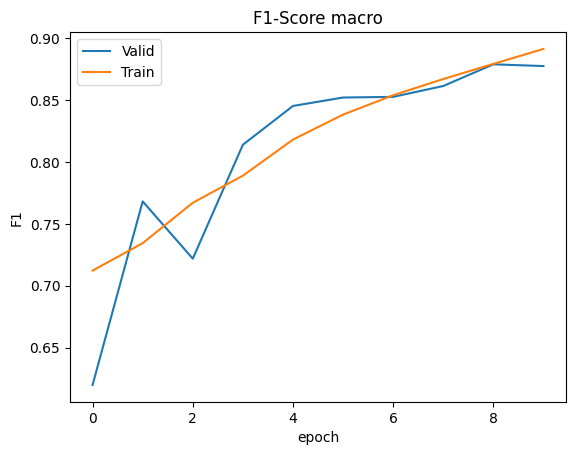

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(len(f1_macro_valid_history)),f1_macro_valid_history, label='Valid')
plt.plot(range(len(f1_macro_valid_history)), f1_macro_train_history, label='Train')
plt.title('F1-Score macro')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend(loc='best')
plt.show()

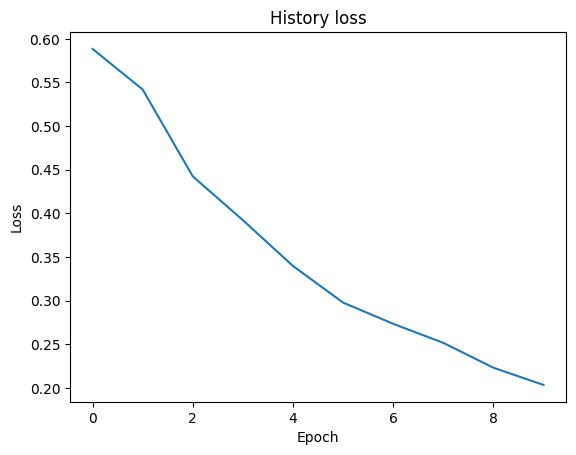

In [44]:
plt.plot(range(len(history_train_loss)), history_train_loss)
plt.title('History loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()